In [1]:
#Import libraries

import time
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
#from skbio.stats.composition import clr

import matplotlib.pyplot as plt
import matplotlib.axes as axes
#import os
#For CLR of ADTs
import scipy
import scipy.stats
from sklearn.preprocessing import scale
import os
import copy
import glob
import seaborn as sns
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)


sc.logging.print_versions() 
sc.settings.set_figure_params(dpi=100, dpi_save = 1000)

-----
anndata     0.9.2
scanpy      1.9.3
-----
PIL                 9.4.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.8
decorator           5.1.1
executing           1.2.0
gmpy2               2.1.2
h5py                3.9.0
igraph              0.10.6
importlib_resources NA
ipykernel           6.25.1
jedi                0.19.0
joblib              1.3.2
kiwisolver          1.4.4
leidenalg           0.10.1
llvmlite            0.40.1
matplotlib          3.7.2
mpl_toolkits        NA
mpmath              1.3.0
natsort             8.4.0
numba               0.57.1
numpy               1.24.4
opt_einsum          v3.3.0
packaging           23.1
pandas              2.0.3
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.10.0
prompt_toolkit      3.

In [2]:
import anndata

In [3]:
#Set font size of plot
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [4]:
from matplotlib import colors
colors2 = plt.cm.Reds(np.linspace(0, 1, 512))
colors3 = plt.cm.Greys_r(np.linspace(0.8,1,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
#proj_path = "/wynton/group/fong/zenghua/prostate_analysis/"
proj_path = './'
# os.chdir(proj_path+'batch1_data_for_analysis/analysis/')

In [6]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

### Plot known marker genes for certain cell types
These known markers can help you decide what cell type each cluster is likely to be

In [7]:
# markers = ["PTPRC","CD3D","CD8A","CD4","IL7R",                #all Tcell
#            "IL2RA","FOXP3","CCR7","GZMB","NKG7",              #Tcell,Tcell,Tcell,Tcell,NK
#            "GNLY","NCAM1","CD19","MS4A1","MZB1",              #NK,?, B,B,Plasma
#            "CD38","CD14","FCGR3A","FCGR2A","CSF1R",           #Tcell,Myeloid,Myeloid,Myeloid,Myeloid
#            "CD68","HLA-DQA1","FLT3","FCER1A","KIT",           #Myeloid,Myeloid,Myeloid?,Myeloid,Mast
#            "KLK3","PCA3","SPINK1",'TP63',"EPCAM",             #Prostate Carcinoma,Prostate Carcinoma,Prostate Carcinoma,Prostate Carcinoma,Prostate Epithelial
#            "WFDC2",                                           #Prostate Epithelial
#            "COL1A2","COL6A1","MYLK","VWF","PECAM1"]           #Fibroblasts,Fibroblasts,Fibroblasts,Endothelial,Endothelial

It looks like the batch mixed well. Since each time umap run, it may have different image, so we save the current results to keep it the same. Later on, we only need to use the saved results.

In [8]:
adata = sc.read_h5ad('./adata_batch1_batch2_batch_correction_with_harmony_and_umap.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 233895 × 5000
    obs: 'doublet_call', 'pool', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'sample_id', 'arm', 'pool_num', 'patient_sample', 'patient_id', 'time_point', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'pool_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 

In [10]:
adata.obs['patient_sample'].value_counts().to_csv('./patient_sample_cell_count.csv')

In [11]:
# total_markers = {'T cells':["CD3D","CD8A","CD4","CD45", 'NCAM1','CD19','CD20'], # No NCAM1, CD19, CD20
#                  'T CD56':["CD3D","CD8A","CD4","CD45", 'NCAM1','CD19','CD20'], # No CD19, CD20
#                  'NK':['NCAM1','CD45', 'CD3', 'CD19', 'CD15', 'CD14'], # No CD3,CD19, CD20, CD15, CD14
                 
#                    'cytotoxic':['GZMB','GZMK', 'NKG7',"GNLY",'PRF1'], #"GZMA",,'IFNG','CD160'
#                    'naive/memory':['CCR7','SELL'], #naive, cd25=IL2RA,,'IL2RA','CD44']
#                    'gdT':['TRDC','TRDV2'],
#                    'Trm':['CD69'], #'CXCR6'  #this is just generic marker for resident memory but not good usually
#                    'MAIT':['KLRB1','CXCR6'], #'TRAT1',
#                    'exhaustion':['PDCD1','CTLA4','TIGIT'], #'TOX',
#                    'Treg':['FOXP3'],
                   
#                   #  'Prolif':['MKI67','CCNK'], #,'TUBB'
#                    "Mono/Mac":["CD14","FCGR3A","CSF1R"], #,"ITGAM","CD68","CD163", "APOE",'C1QC','C1QA',"MRC1","SELENOP","FOLR2"]                      
#                    "MDSC":['S100A8', "FCN1"], #MDSC, 'CXCR2',"S100A2","IL10","VEGFA",'CSF3R',"VCAN"
#                     'cDCs':["FCER1A","CD1C","CLEC10A"],
#                   'pDCs':["TCF4","IRF7",'CLEC4C'], #pDC
#                   'B cells':['CD19','MS4A1'],
#                   'Plasma':["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
#                   # 'Mast':['KIT','ITGA4']
#                   }

In [12]:
# markers_in_data = list()
# for k in total_markers.keys():
#     markers_in_data.extend(total_markers[k])
# markers_in_data

In [13]:
# for i in range(14):
        
#         for j in list(total_markers.keys()):
#                 print(f"Plot of markers of cluster {i} by cell types")
#                 print(f"Plot of markers of cell type {j}")
#                 # print(ct_markers[j])
#                 # print(marker_clust[i])
#                 mk = list(set(total_markers[j]).intersection(set(adata.var_names)))
#                 if len(mk) != 0:                       
#                         print(mk)
#                         tmp_adata = adata[adata.obs['leiden'] == str(i)]
#                         sc.pl.umap(tmp_adata, color = mk, ncols = 4, vmin = 0, vmax = "p99",
#                         sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
#                                 frameon=False,
#                                 cmap="Reds",)
#                         sc.pl.umap(adata, color = mk, ncols = 4, vmin = 0, vmax = "p99",
#                         sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
#                                 frameon=False,
#                                 cmap="Reds",)
#                         sc.pl.umap(adata, color =['leiden'],legend_loc = 'on data', legend_fontsize='small', show = True, save = False) 

In [14]:
# for k in total_markers.keys():
#         print(f"Markers for cell type {k}")
#         l = list(set(total_markers[k]).intersection(adata.var_names))
#         sc.pl.umap(adata, color =l, ncols = 4, vmin = 0, vmax = "p99",
#         sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
#                 frameon=False,
#                 cmap="Reds",)
#         sc.pl.umap(adata, color =['leiden'],legend_loc = 'on data', legend_fontsize='small', show = True, save = False) 

In [15]:
# markers = ["PTPRC","CD3D","CD8A","CD4","IL7R",              #all Tcell
#            "IL2RA","FOXP3","CCR7","GZMB","NKG7",              #Tcell,Tcell,Tcell,Tcell,NK
#            "GNLY","NCAM1","CD19","MS4A1","MZB1",              #NK,?, B,B,Plasma
#            "CD38","CD14","FCGR3A","FCGR2A","CSF1R",           #Tcell,Myeloid,Myeloid,Myeloid,Myeloid
#            "CD68","HLA-DQA1","FLT3","FCER1A","KIT"           #Myeloid,Myeloid,Myeloid?,Myeloid,Mast
#            ]  

In [16]:
# mk_in_dat = list(set(markers).intersection(adata.var_names))

In [17]:
# markers = ["PTPRC","CD3D","CD8A","CD4","IL7R",                #all Tcell
#            "IL2RA","FOXP3","CCR7","GZMB","NKG7",              #Tcell,Tcell,Tcell,Tcell,NK
#            "GNLY","NCAM1","CD19","MS4A1","MZB1",              #NK,?, B,B,Plasma
#            "CD38","CD14","FCGR3A","FCGR2A","CSF1R",           #Tcell,Myeloid,Myeloid,Myeloid,Myeloid
#            "CD68","HLA-DQA1","FLT3","FCER1A","KIT",           #Myeloid,Myeloid,Myeloid?,Myeloid,Mast
#            "KLK3","PCA3","SPINK1",'TP63',"EPCAM",             #Prostate Carcinoma,Prostate Carcinoma,Prostate Carcinoma,Prostate Carcinoma,Prostate Epithelial
#            "WFDC2",                                           #Prostate Epithelial
#            "COL1A2","COL6A1","MYLK","VWF","PECAM1"]   

marker_genes = {
    "Myeloid": ["CD14","FCGR3A","FCGR2A","CSF1R",           #Tcell,Myeloid,Myeloid,Myeloid,Myeloid
           "CD68","HLA-DQA1","FLT3","FCER1A"],
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "ID2-hi myeloid prog": [
        "CD14",
        "ID2",
        "VCAN",
        "S100A9",
        "CLEC12A",
        "KLF4",
        "PLAUR",
    ],
    'pDCs':["TCF4","IRF7",'CLEC4C'], 
    'cDCs':["FCER1A","CD1C","CLEC10A"],
    "cDC1": ["CLEC9A", "CADM1"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Normoblast": ["SLC4A1", "SLC25A37", "HBB", "HBA2", "HBA1", "TFRC"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "GRIK4", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Lymph prog": [
        "VPREB1",
        "MME",
        "EBF1",
        "SSBP2",
        "BACH2",
        "CD79B",
        "IGHM",
        "PAX5",
        "PRKCE",
        "DNTT",
        "IGLL1",
    ],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B cells":['CD19','MS4A1'],
    "B1 B": [
        "MS4A1",
        "SSPN",
        "ITGB1",
        "EPHA4",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "CD38",
        "XBP1",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
        "ZNF215",
    ],  # Note IGHD and IGHM are negative markers
    "Transitional B": ["MME", "CD38", "CD24", "ACSM3", "MSI2"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "RF4", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T activated": ["CD4", "IL7R", "TRBC2", "ITGB1"],
    "CD4+ T naive": ["CD4", "IL7R", "TRBC2", "CCR7"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T activation": ["CD69", "CD38"],  # CD69 much better marker!
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "Treg":['FOXP3'],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
    "G/M prog": ["MPO", "BCL2", "KCNQ5", "CSF3R"],
    "HSC": ["NRIP1", "MECOM", "PROM1", "NKAIN2", "CD34"],
    "MK/E prog": [
        "ZNF385D",
        "ITGA2B",
        "RYR3",
        "PLCB1",
    ],  # Note PLCB1 is a negative marker
}
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [ ]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names="CD3D",
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


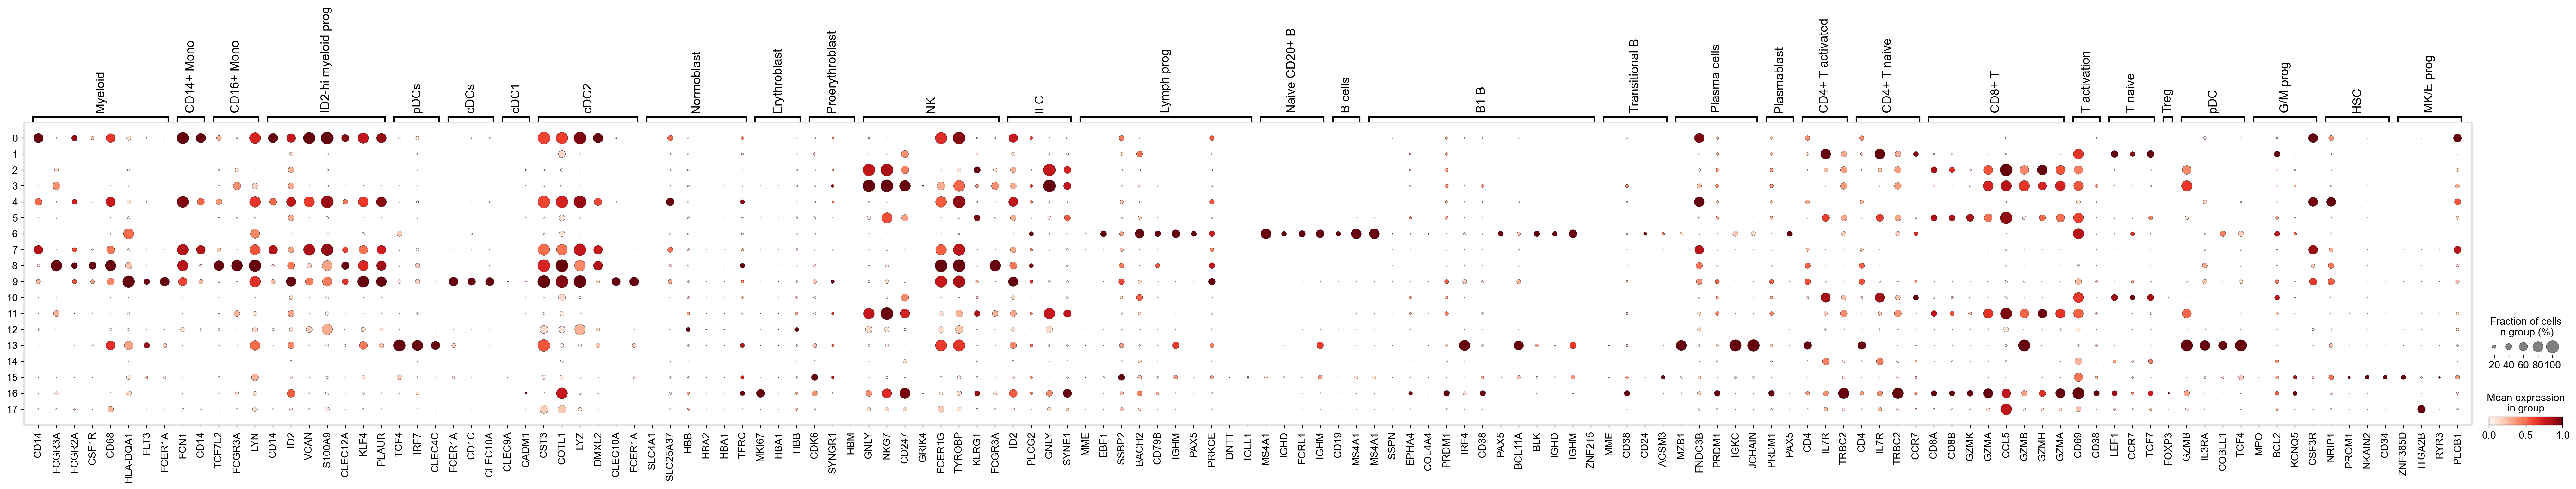

In [19]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [ ]:
for ct in marker_genes_in_data:
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        adata,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility

In [21]:
adata

AnnData object with n_obs × n_vars = 233895 × 5000
    obs: 'doublet_call', 'pool', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'sample_id', 'arm', 'pool_num', 'patient_sample', 'patient_id', 'time_point', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'pool_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 

To avoid doing log twice, just reload raw count

In [22]:
adata.X = adata.layers['raw']

In [23]:
adata.X[1:10,1:10].todense()

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.],
        [11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]], dtype=float32)

In [24]:
# sc.tl.score_genes(adata, markers_in_data, ctrl_size = len(markers_in_data), 
#                   score_name = "markers_in_data", use_raw = False)
# # fn = "_prolif_score.pdf"
# # sc.pl.umap(adata, color = "prolif_score", vmin = 0, vmax = 1, save = fn)
# sc.pl.umap(adata, color = markers_in_data, vmin = 0, vmax = 1)

In [25]:
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, use_raw = False, 
                     n_genes = 2000, groupby = "leiden",
                       copy=False, method='wilcoxon',
                        corr_method='benjamini-hochberg', key_added="dea_leiden")


ranking genes
    finished: added to `.uns['dea_leiden']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:42)


In [26]:
adata.uns['dea_leiden']['names']

rec.array([('S100A8', 'LTB', 'CCL5', 'GNLY', 'JARID2', 'CCL5', 'CD79A', 'S100A8', 'LST1', 'HLA-DRA', 'MTRNR2L8', 'MTRNR2L8', 'S100A8', 'JCHAIN', 'LTB', 'SOX4', 'STMN1', 'PPBP'),
           ('S100A9', 'IL7R', 'GNLY', 'NKG7', 'HIF1A', 'IL32', 'MS4A1', 'S100A9', 'AIF1', 'HLA-DPA1', 'LTB', 'NKG7', 'HBB', 'IGKC', 'IL7R', 'AC084033.3', 'MT2A', 'NRGN'),
           ('LYZ', 'CD3E', 'NKG7', 'CTSW', 'IFNGR2', 'GZMK', 'CD74', 'VCAN', 'SAT1', 'HLA-DPB1', 'IL7R', 'CCL5', 'S100A9', 'TCF4', 'AL138963.3', 'CDK6', 'TUBB', 'PF4'),
           ...,
           ('TRIM55', 'IGLV3-1', 'AKAP12', 'PRDM16', 'ADGRE1', 'AC012184.2', 'HAND2-AS1', 'GAD1', 'MYO1A', 'FLVCR2', 'CENPP', 'IGHG1', 'LINC02362', 'IGHV3-74', 'AL360227.1', 'RAB23', 'AL109930.1', 'XCR1'),
           ('AL356234.2', 'ATP6V1E2', 'TRBV6-6', 'IGHG1', 'VGF', 'CCDC175', 'HBA2', 'NFIB', 'SLIT2', 'AL096865.1', 'C1QTNF1', 'IGKV2-30', 'RGPD2', 'RANBP17', 'CD1E', 'FA2H', 'AL451050.2', 'C1QTNF1'),
           ('NRP1', 'LINC01705', 'GCSAML', 'IGHA2', 'OPN3', 

In [27]:
result = adata.uns['dea_leiden']
groups = result['names'].dtype.names
de_df = pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names','logfoldchanges','pvals_adj','scores']})

In [28]:
de_df.to_csv('./rank_gene_expression_by_group_batch1_batch2.csv')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


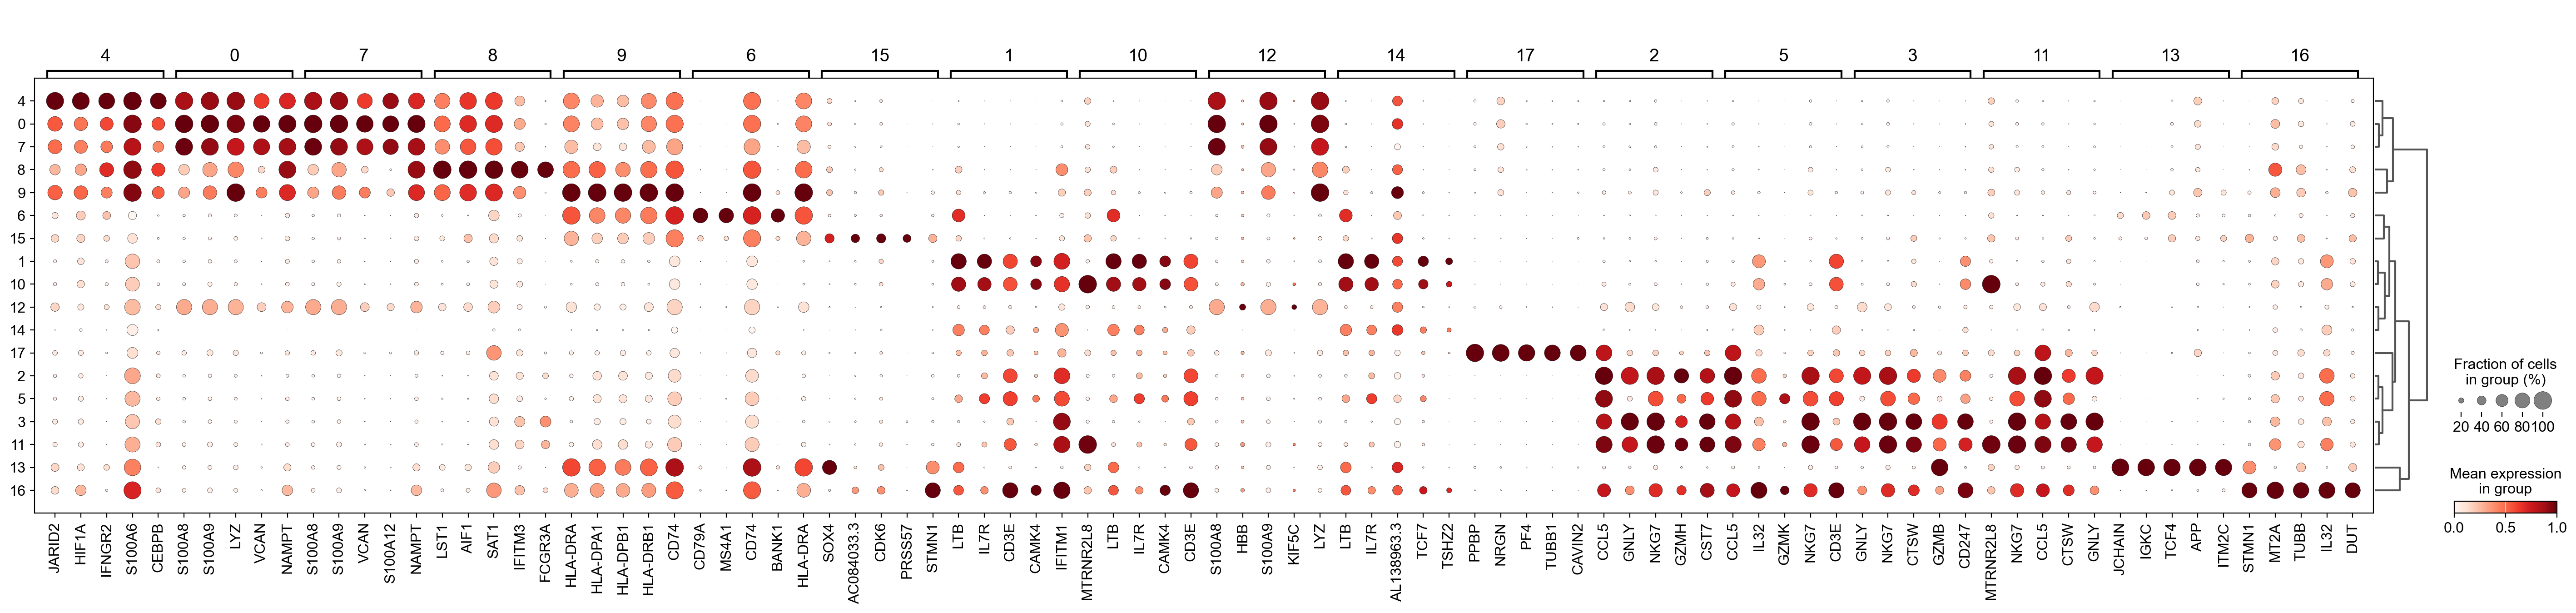

In [29]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5, key="dea_leiden"
)


In [30]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden",
    key_added="dea_leiden_filtered",
)

Filtering genes using: min_in_group_fraction: 0.2 min_fold_change: 1, max_out_group_fraction: 0.2


# Same plot above by filtered: Filtering genes using: min_in_group_fraction: 0.2 min_fold_change: 1, max_out_group_fraction: 0.2

# This is useful for differentiating clusters that we cannot decide from above image

categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2, etc.


/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


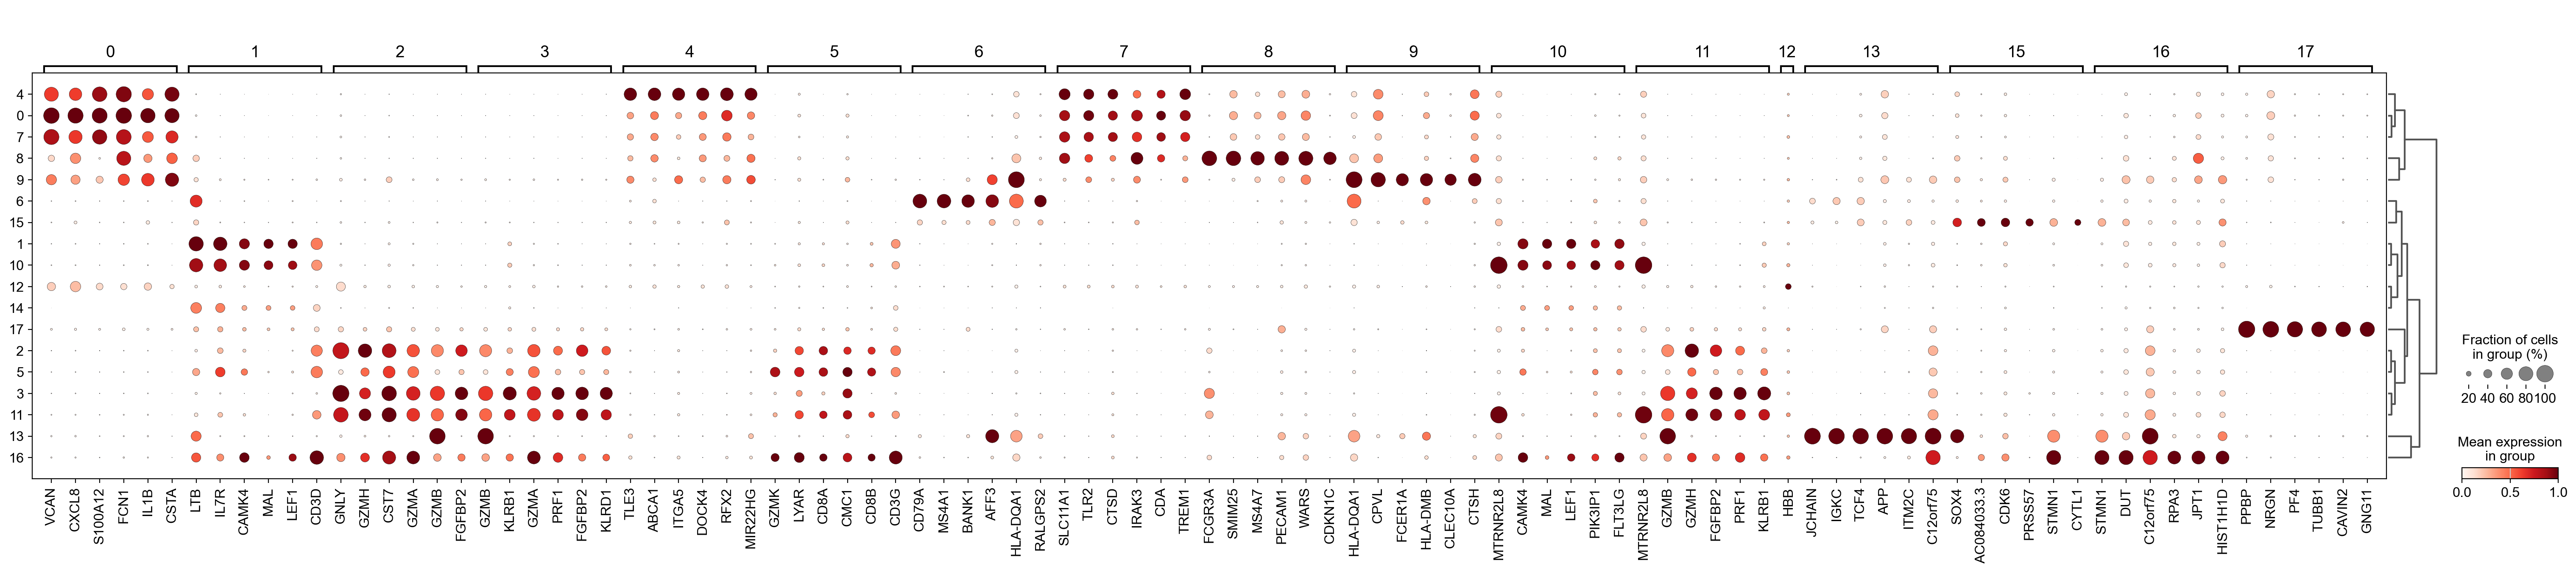

In [31]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden",
    standard_scale="var",
    n_genes=6,
    key="dea_leiden_filtered",
)

/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


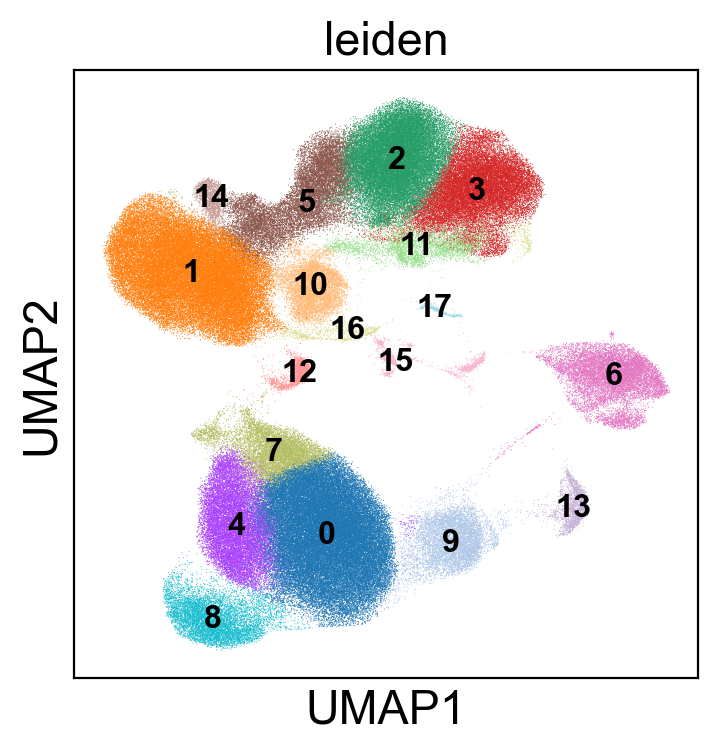

In [32]:
sc.pl.umap(adata, color =['leiden'],legend_loc = 'on data', legend_fontsize='small', show = True, save = False) 

In [33]:
cell_annotation_corrected = {'0': 'Monocytes',
                   '1': 'Naive T cell',
                   '2': 'Cytotoxic CD8 GZMB T cell',
                   '3': 'NK cell',
                   '4': 'Monocytes',
                   '5': 'Cytotoxic CD8 GZMK T cell',
                   '6': 'B cell',
                   '7': 'Monocytes',
                   '8': 'CD16+ (FCGR3A) dendritic cells',
                   '9': 'Dendritic cell',
                   '10': 'Central memory T cell',
                   '11': 'gamma delta T cell',
                   '12': 'Erythroid cell', # Gene HBB (filtered dot plot) https://panglaodb.se/search.html?query=%22HBB%22&species=3&tumor=0&nonadult=0,  http://117.50.127.228/CellMarker/CellMarkerSearch.jsp
                   '13': 'Plasma cell',
                    '14': 'T cell',
                    '15':'HSC', # Gene STMN1 (filtered dot plot) https://www.proteinatlas.org/ENSG00000117632-STMN1/single+cell+type, SOX4 https://www.proteinatlas.org/ENSG00000124766-SOX4/immune+cell
                    '16': 'T cell',
                    '17': 'Platelets'
                   }

In [34]:
adata.obs['corrected_cell_type'] = [cell_annotation_corrected[adata.obs['leiden'][i]] for i in range(adata.obs.shape[0])]

/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


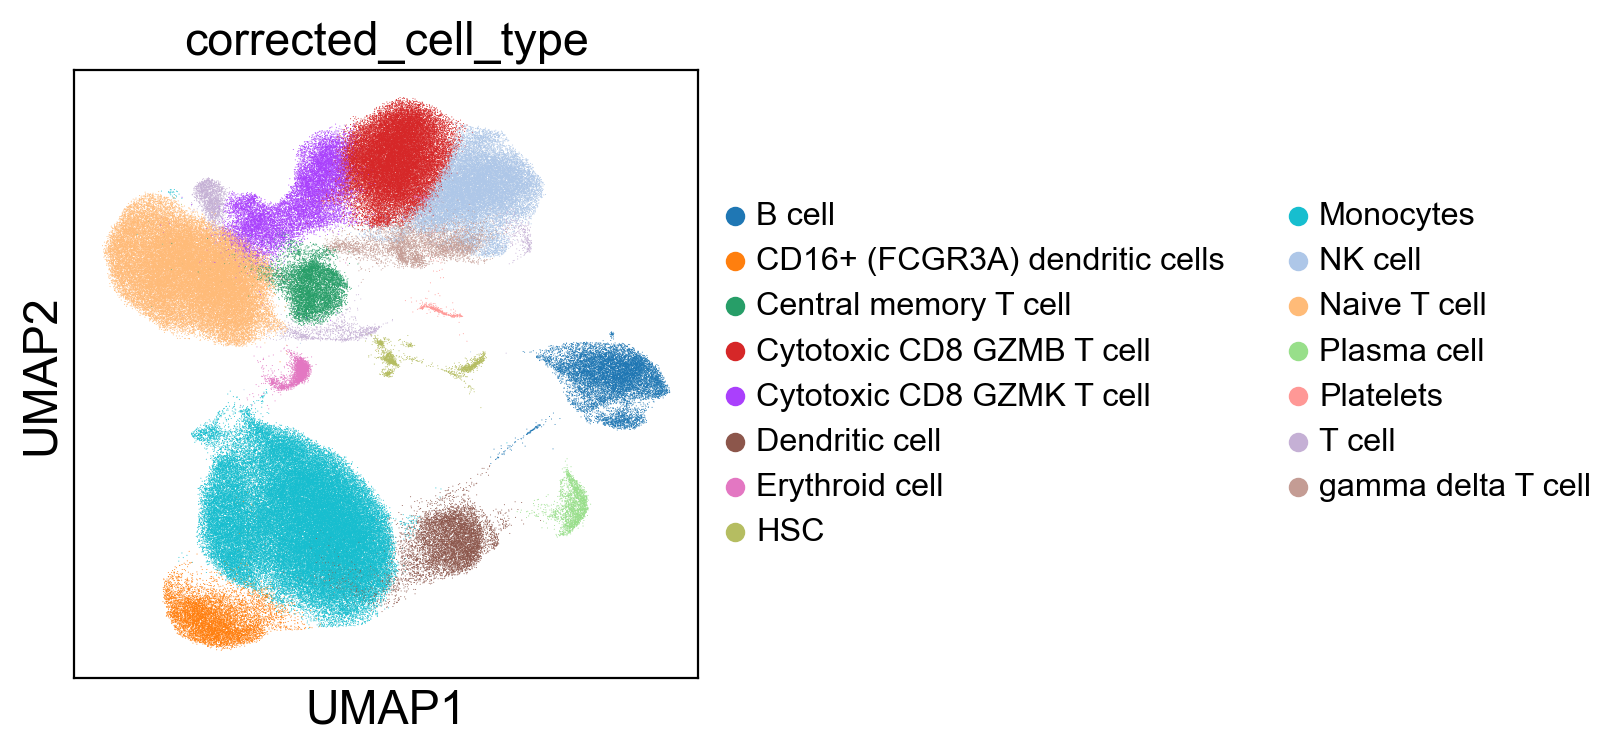

In [35]:
sc.pl.umap(adata, color =['corrected_cell_type'], legend_fontsize='small', show = True, save = False) 

/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


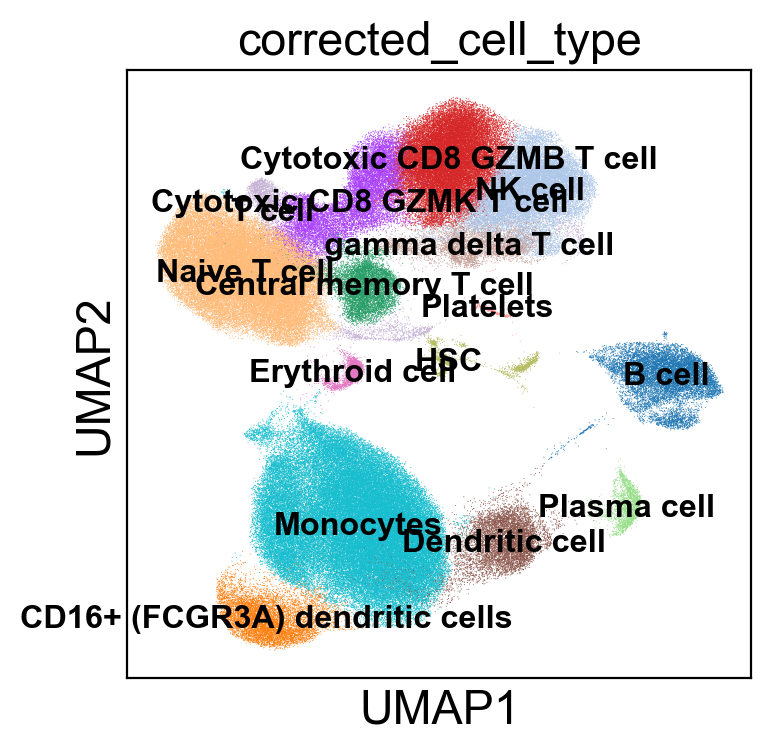

In [36]:
# sc.pl.umap(adata, color =['corrected_cell_type'], legend_fontsize='small', show = True, save = False) 
sc.pl.umap(adata, color =['corrected_cell_type'],legend_loc = 'on data', legend_fontsize='small', show = True, save = False) 

/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


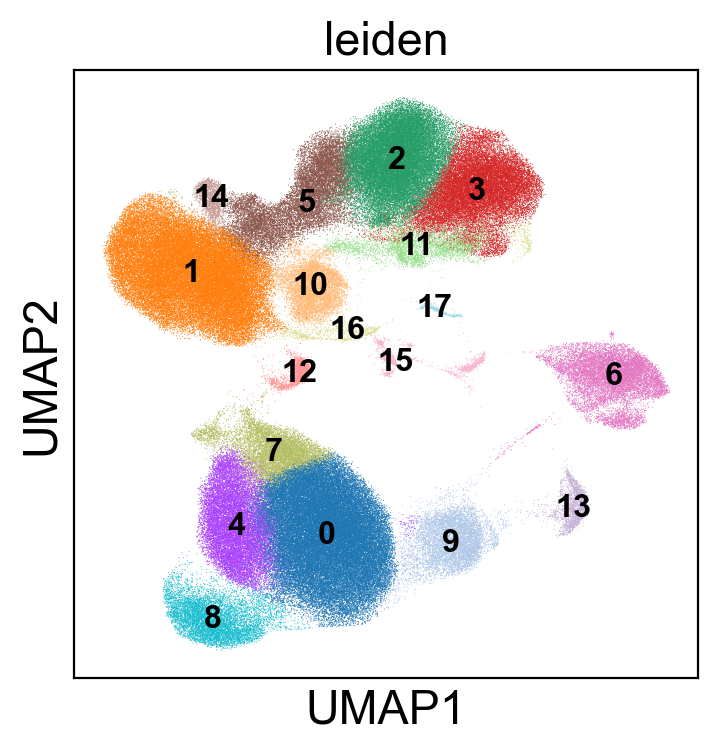

In [37]:
sc.pl.umap(adata, color =['leiden'],legend_loc = 'on data', legend_fontsize='small', show = True, save = False) 